# Import packages

In [66]:
# !pip install -r multiff_analysis/requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

project_folder = '/Users/dusiyi/Documents/Multifirefly-Project'
os.chdir(project_folder)
sys.path.append(os.path.join(project_folder, 'multiff_analysis', 'methods'))

from data_wrangling import general_utils, specific_utils, process_monkey_information
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from non_behavioral_analysis.neural_data_analysis.get_neural_data import neural_data_processing
from non_behavioral_analysis.neural_data_analysis.visualize_neural_data import plot_neural_data, plot_modeling_result
from non_behavioral_analysis.neural_data_analysis.model_neural_data import cca_class, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from non_behavioral_analysis.neural_data_analysis.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from non_behavioral_analysis.neural_data_analysis.planning_neural import planning_neural_class, planning_neural_utils
from non_behavioral_analysis.neural_data_analysis.decode_targets import behav_features_to_keep, decode_target_class, plot_gpfa_utils, decode_target_utils, fit_gpfa_utils, gpfa_regression_utils

import sys
import math
import gc
import subprocess
from pathlib import Path
from importlib import reload

# Third-party imports
import numpy as np
from numpy import var
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
import torch
from numpy import pi

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca

# To fit gpfa
import numpy as np
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process
from elephant.gpfa import GPFA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from elephant.gpfa import gpfa_core, gpfa_util

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")


pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)


%load_ext autoreload
%autoreload 2

done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
free_up_memory = False
dec.streamline_making_behav_and_neural_data(free_up_memory=free_up_memory)
dec.get_x_and_y_var()
dec.pursuit_data.head(3)

NameError: name 'stop' is not defined

In [ ]:
stop!!

# Get data

In [2]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"
dec = decode_target_class.DecodeTargetClass(raw_data_folder_path=raw_data_folder_path,
                                                               bin_width=0.02, window_width=0.05)

In [3]:
free_up_memory = False
dec.streamline_making_behav_and_neural_data(free_up_memory=free_up_memory)
dec.get_x_and_y_var()
dec.pursuit_data.head(3)

Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Schro/data_0416/ff_dataframe.h5


/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/methods/non_behavioral_analysis/neural_data_analysis/neural_vs_behavioral/prep_monkey_data.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  monkey_info_in_bins = monkey_info_in_bins.bfill(


Retrieved target_df
Warnings: At least one ff has a lower bound of ff_angle_boundary equal to its upper bound after clipping, meaning that the ff's angle to boundary is greater than 90 degrees. Please check the input.

NA Values Analysis for behav_data_all (179,947 rows)

Columns with NA values:
------------------------------------------------------------
time_since_target_last_seen               123,681 (  68.7%)
target_last_seen_distance                 123,681 (  68.7%)
time_target_last_seen                     123,681 (  68.7%)
target_last_seen_angle                    123,681 (  68.7%)
target_last_seen_angle_to_boundary        123,681 (  68.7%)
monkey_x_target_last_seen                 123,681 (  68.7%)
monkey_y_target_last_seen                 123,681 (  68.7%)
monkey_angle_target_last_seen             123,681 (  68.7%)
cum_distance_when_target_last_seen        123,681 (  68.7%)
distance_from_monkey_pos_target_last_seen  123,681 (  68.7%)
cum_distance_since_target_last_seen      

NameError: name 'stop' is not defined

# Target columns lags

In [4]:
# dec._make_or_retrieve_target_df(exists_ok=True, fill_na=False)
# dec.get_basic_data()

In [5]:
# lag_number = - dec.max_y_lag_number
# y_var_lags2 = dec.y_var_lags.merge(dec.y_var[['bin', 'target_index']], on='bin', how='left')
# temp_target_df = decode_target_utils.process_target_columns_in_lags(y_var_lags2, lag_number, 
#                                                                     dec.monkey_information, dec.ff_real_position_sorted, dec.ff_dataframe, dec.ff_caught_T_new, dec.curv_of_traj_df)

In [10]:
dec.y_var.columns

Index(['bin', 'point_index', 'monkey_speed', 'monkey_angle', 'monkey_dw',
       'monkey_ddw', 'monkey_ddv', 'monkey_speeddummy',
       'whether_new_distinct_stop', 'delta_distance', 'LDy', 'LDz', 'RDy',
       'RDz', 'gaze_mky_view_x_l', 'gaze_mky_view_y_l',
       'gaze_mky_view_angle_l', 'gaze_mky_view_x_r', 'gaze_mky_view_y_r',
       'gaze_mky_view_angle_r', 'eye_world_speed', 'valid_view_point_l',
       'valid_view_point_r', 'num_alive_ff', 'num_visible_ff',
       'min_ff_distance', 'min_abs_ff_angle', 'min_abs_ff_angle_boundary',
       'min_visible_ff_distance', 'min_abs_visible_ff_angle',
       'min_abs_visible_ff_angle_boundary', 'catching_ff', 'any_ff_visible',
       'target_distance', 'target_angle', 'target_angle_to_boundary',
       'target_rel_x', 'target_rel_y', 'time_since_target_last_seen',
       'target_last_seen_distance', 'target_last_seen_angle',
       'target_last_seen_angle_to_boundary', 'target_visible_dummy',
       'time_since_last_capture', 'traj_curv

In [8]:
dec.y_var['target_index']

0          1
1          1
2          1
3          1
4          1
        ... 
10670    468
10671    468
10672    468
10673    468
10674    468
Name: target_index, Length: 10675, dtype: int64

In [12]:
target_df_lags = decode_target_utils.make_target_df_lags(dec.y_var, dec.max_y_lag_number)

In [ ]:
if 'target_index' not in dec.y_var_lags.columns:
    dec.y_var_lags = dec.y_var_lags.merge(dec.y_var[['bin', 'target_index']], on='bin', how='left')

In [ ]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

In [ ]:
import ipdb

In [ ]:
%pdb on

Automatic pdb calling has been turned ON


In [ ]:
y_var_lags = decode_target_utils.process_target_columns_in_lags(dec.y_var_lags, target_df_lags, dec.max_y_lag_number)

In [ ]:
temp_target_df = decode_target_utils.add_target_info_based_on_target_index_and_point_index(temp_target_df, dec.monkey_information, dec.ff_real_position_sorted, 
                                                                                            dec.ff_dataframe, dec.ff_caught_T_new, dec.curv_of_traj_df)


NameError: name 'temp_target_df' is not defined

## inspect

In [ ]:
temp_target_df2 = dec.y_var[['bin', 'target_index', 'time']].copy()
for col in ['time_target_last_seen', 'target_last_seen_distance', 'time_since_target_last_seen']:
    temp_target_df2[f'{lag_number}_{col}'] = y_var_lags2[f'{col}_{lag_number}']
    temp_target_df2[col] = dec.y_var[col]
temp_target_df2

,bin,target_index,time,-5_time_target_last_seen,time_target_last_seen,-5_target_last_seen_distance,target_last_seen_distance,-5_time_since_target_last_seen,time_since_target_last_seen
0,1161,1,23.23504,23.21834,23.21834,244.05748,244.05748,0.11630,0.01669
1,1162,1,23.25155,23.21834,23.21834,244.05748,244.05748,0.13285,0.03321
2,1163,1,23.26827,23.21834,23.21834,244.05748,244.05748,0.14949,0.04992
3,1164,1,23.28476,23.21834,23.21834,244.05748,244.05748,0.16599,0.06642
4,1165,1,23.30168,23.21834,23.21834,244.05748,244.05748,0.18273,0.08334
...,...,...,...,...,...,...,...,...,...
10670,179872,468,3597.44249,3596.64567,3596.64567,125.11175,125.11175,0.89655,0.79683
10671,179873,468,3597.47576,NaN,3596.64567,NaN,125.11175,NaN,0.83009
10672,179874,468,3597.49224,NaN,3596.64567,NaN,125.11175,NaN,0.84658
10673,179875,468,3597.50893,NaN,3596.64567,NaN,125.11175,NaN,0.86327


In [ ]:
na_rows, na_cols = general_utils.find_rows_with_na(temp_target_df)
duplicate_rows = general_utils.find_duplicate_rows(temp_target_df, column_subset=None)


No NA values found in DataFrame

🔍 Duplicate Rows Analysis:

Found 2 duplicate rows

Duplicate rows:
------------------------------------------------------------
       target_distance_5  target_angle_5  target_angle_to_boundary_5  \
10371          159.43123        -0.01182                    -0.00000   
10372          159.43123        -0.01182                    -0.00000   

       target_rel_x_5  target_rel_y_5  ...  \
10371         1.88419       159.42010  ...   
10372         1.88419       159.42010  ...   

       distance_from_monkey_pos_target_last_seen_5  \
10371                                     93.61758   
10372                                     93.61758   

       cum_distance_since_target_last_seen_5  \
10371                               93.63954   
10372                               93.63954   

       d_heading_since_target_last_seen_5  target_x_5  target_y_5  
10371                             0.08302   457.70046  -706.58552  
10372                             0.0

# GPFA

## get data for GPFA

In [ ]:
dec.single_vis_target_df.columns

Index(['target_index', 'last_vis_point_index', 'last_vis_ff_index',
       'nearby_vis_ff_indices', 'time_since_last_vis', 'last_vis_dist',
       'last_vis_cum_dist', 'last_vis_ang', 'last_vis_ang_to_bndry',
       'last_vis_target_dist', 'last_vis_target_ang',
       'last_vis_target_ang_to_bndry', 'abs_last_vis_ang',
       'abs_last_vis_ang_to_bndry', 'abs_last_vis_target_ang',
       'abs_last_vis_target_ang_to_bndry', 'nearby_alive_ff_indices',
       'num_nearby_vis_ff', 'ff_caught_time', 'ff_caught_point_index',
       'last_vis_time', 'segment', 'seg_start_time', 'seg_end_time',
       'seg_duration'],
      dtype='object')

In [ ]:
dec.prepare_spikes_for_gpfa()

print(len(dec.spiketrains))
print(len(dec.spiketrains[0]))
print(len(dec.spiketrains[0][2]))

169
86
21


## fit gpfa

In [ ]:
len(dec.spiketrains)

169

In [ ]:
dec.get_gpfa_traj(latent_dimensionality=10)


TypeError: GPFA.__init__() got an unexpected keyword argument 'bin_width_w_unit'

> /Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/methods/non_behavioral_analysis/neural_data_analysis/decode_targets/decode_target_class.py(270)get_gpfa_traj()
    268     def get_gpfa_traj(self, latent_dimensionality=10):
    269 
--> 270         gpfa_3dim = GPFA(bin_width_w_unit=self.bin_width_w_unit,
    271                          x_dim=latent_dimensionality)
    272         self.trajectories = gpfa_3dim.fit_transform(self.spiketrains)



In [ ]:
stop!

## plot latent dimensions

In [ ]:
plot_gpfa_utils.plot_gpfa_traj_3d_uniform_color()


In [ ]:
# First, enable interactive mode in your notebook
%matplotlib inline

# Import required modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Create the interactive plot
fig, ax = plot_gpfa_utils.plot_gpfa_traj_3d(
    trajectories=dec.trajectories,
    figsize=(15, 5),
    linewidth_single_trial=0.75,
    alpha_single_trial=0.3,
    linewidth_trial_average=2,
    title='Latent dynamics extracted by GPFA',
    view_azim=-5,
    view_elev=60
)

plt.show()

In [ ]:
# fig = plot_gpfa_utils.plot_gpfa_traj_3d_plotly(trajectories)

In [ ]:
# Find variance explained by each latent dimension
traj_stack = np.stack(dec.trajectories, axis=0)  # shape: (n_trials, 3, T)
var_by_dim = var(traj_stack, axis=(0, 2))    # variance across trials and time
var_by_dim /= var_by_dim.sum()               # normalize to get explained variance ratio
print("Variance explained by each latent dimension:", var_by_dim)


In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title('Latent dynamics extracted by GPFA')
ax.set_xlabel('Time [s]')

average_trajectory = np.mean(, axis=0)
time = np.arange(len(average_trajectory[0])) * 0.02  # assuming all trajectories have the same length

for i, x in enumerate(average_trajectory):
    ax.plot(time, x, label=f'Dim {i+1}')

ax.legend()

plt.tight_layout()
plt.show()


## prepare data for regression

## regression

In [ ]:
dec.common_t_stop = max(dec.spike_segs_df['t_duration']) * pq.s + dec.bin_width_w_unit        

In [ ]:
dec.get_gpfa_and_behav_data_for_all_trials()

In [ ]:
max_timepoints = int(1.5/0.02)
scores_by_time, times = gpfa_regression_utils.time_resolved_regression_variable_length(dec.gpfa_trials, dec.behavior_trials, time_step=0.02, cv_folds=5, max_timepoints=max_timepoints)

In [ ]:
behavior_labels = dec.pursuit_data_by_trial.drop(columns=['segment']).columns
len(behavior_labels)
scores_by_time_df = pd.DataFrame(scores_by_time, columns=behavior_labels)
# see the percentage of 1 of this dummy variable
dec.pursuit_data_by_trial[['whether_new_distinct_stop']].sum()/len(dec.pursuit_data_by_trial)

In [ ]:
gpfa_regression_utils.plot_time_resolved_scores(scores_by_time, times, behavior_labels=behavior_labels)


In [ ]:
trial_counts = np.array([sum(latent.shape[0] > t for latent in gpfa_trials)
                         for t in range(scores_by_time.shape[0])])
plt.plot(times, trial_counts)
plt.xlabel("Time (s)")
plt.ylabel("Trials with data")


# Reduce columns in lags

In [ ]:
# dec.reduce_x_var_lags()  # currently not needed bc of the low correlations between neural clusters
dec.reduce_y_var_lags()


====================Dropping lags of features with high correlation for each feature====================
Processing feature 1/60
10 columns of *monkey_angle* dropped: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]
9 columns of *monkey_speeddummy* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
Processing feature 11/60
Processing feature 21/60
9 columns of *valid_view_point_l* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
9 columns of *valid_view_point_r* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
10 columns of *num_alive_ff* dropped: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]
9 columns of *num_visible_ff* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
9 columns of *min_ff_distance* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
9 columns of *min_abs_ff_angle* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
10 columns of *min_abs_ff_angle_boundary* dropped: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]
9 columns of *min_visible_ff_distance* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
9 columns of *min_abs_visible_ff_angle* dropped: [-4, -3, -2, -1,

MissingDataError: exog contains inf or nans

## check result of reducing

In [ ]:
## also check correlations between x vars without lags
high_corr_pair_df, top_n_corr_df = drop_high_corr_vars.get_pairs_of_columns_w_high_corr(
            dec.x_var, corr_threshold=0.8)
top_n_corr_df

# Linear regression (didn't modify yet)

Regressing the behavioral variables individually (as y_var) against all neural activity

## put results in df

In [ ]:
# dec.make_or_retrieve_y_var_lr_resault_df(exists_ok=True)
dec.y_var_lr_result_df = neural_data_modeling.get_y_var_lr_result_df(
                dec.x_var_lags_reduced, dec.y_var)
dec.y_var_lr_result_df.head(5)

##  plot all neural clusters vs one behavioral var

In [ ]:
# drop existing columns involving bin (most likely there's only one or zero after being reduced, because different lags of bins can have very high correlations)
bin_cols = [col for col in dec.y_var_lags_reduced.columns if 'bin' in col]
dec.y_var_lags_reduced.drop(columns=bin_cols, inplace=True)

# then we add the variable bin (so that only the 0 lag is used)
dec.y_var_lags_reduced['bin'] = dec.y_var_lags['bin_0'].astype(int)

In [ ]:


# conduct linear regression on X and y
plt.rcParams["figure.figsize"] = (20, 10)
bins_to_plot = dec.y_var_lags_reduced['bin'].values
for i, column in enumerate(dec.y_var_lags_reduced.columns):

    plot_neural_data.plot_regression(dec.y_var_lags_reduced, column, dec.x_var_lags_reduced, bins_to_plot=bins_to_plot, min_r_squared_to_plot=0.3)
    # if i == 3:
    #     break

##  plot one neural cluster vs one behavioral var

In [ ]:
# plot one neural cluster against one behavioral variable
cluster_num, behavioral_column = 6, 'monkey_speed'
bins_to_plot = range(1000, 1200)
x_values = dec.binned_spikes_df.loc[bins_to_plot, f'unit_{cluster_num}'].values
y_values = dec.pursuit_data[behavioral_column][bins_to_plot]
reg = LinearRegression().fit(x_values.reshape(-1, 1), y_values)

plt.scatter(x_values, y_values, color='blue', s=1)
plt.plot(x_values, reg.predict(x_values.reshape(-1, 1)), color='red', linewidth=1)
plt.show()

# CCA

https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

## No lagging

In [ ]:
cca_no_lag = cca_class.CCAclass(X1=dec.x_var, X2=dec.y_var_reduced, lagging_included=False)

Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.39963 0.35209 0.31528 0.29226 0.26277 0.23855 0.20085 0.19895 0.18979
 0.17374]
% Shared Variance: [0.1597  0.12397 0.0994  0.08542 0.06905 0.05691 0.04034 0.03958 0.03602
 0.03019]


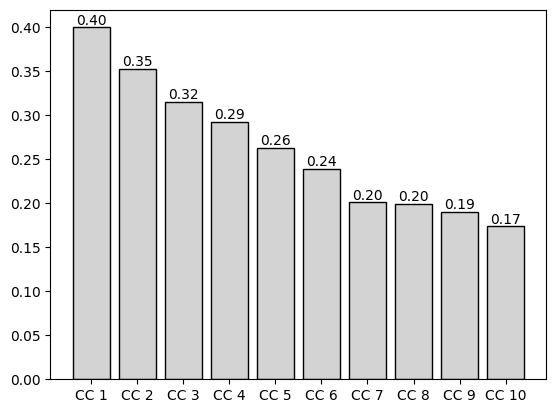

In [ ]:
cca_no_lag.conduct_cca()

## with lags

In [ ]:
cca_lags = cca_class.CCAclass(X1=dec.x_var_lags, X2=dec.y_var_lags_reduced, lagging_included=True)

In [ ]:
dec.y_var_lags_reduced.shape

In [ ]:
cca_lags.conduct_cca()

In [ ]:
gc.collect()

## compare lag vs no lag

In [ ]:
canon_df = pd.DataFrame(cca_no_lag.canon_corr, columns = ['no_lag'])
canon_df[f'lag_{dec.max_lag_number}'] = cca_lags.canon_corr
canon_df['component'] = [f'CC {i+1}' for i in range(cca_lags.n_components)]
# convert canon_df to long format
canon_df_long = pd.melt(canon_df, id_vars=['component'], var_name='lag', value_name='canon_coeff')

In [ ]:
# make a sns bar plot on canon_df_long
plt.figure(figsize=(8, 6))
sns.barplot(x='component', y='canon_coeff', data=canon_df_long, hue='lag')
plt.show()

## cca_inst (choose one between lags and no lag)

In [ ]:
# choose lags
cca_inst = cca_lags

NameError: name 'cca_lags' is not defined

In [ ]:
# choose no lag
cca_inst = cca_no_lag

## loadings

### neurons

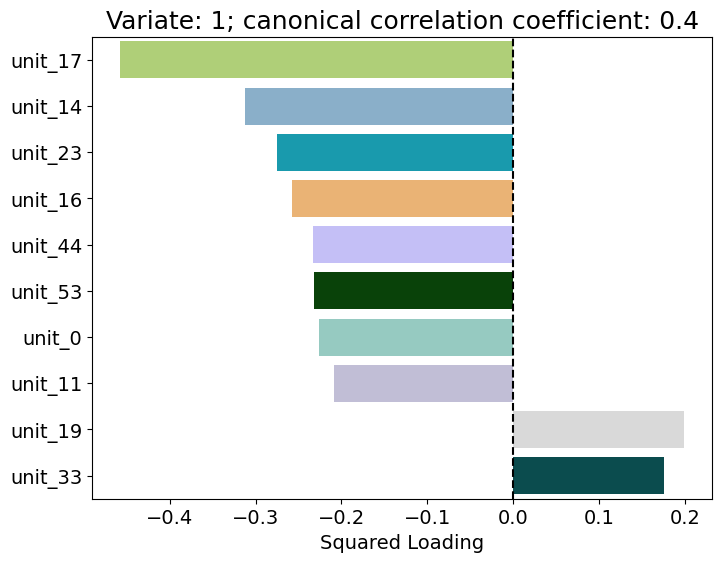

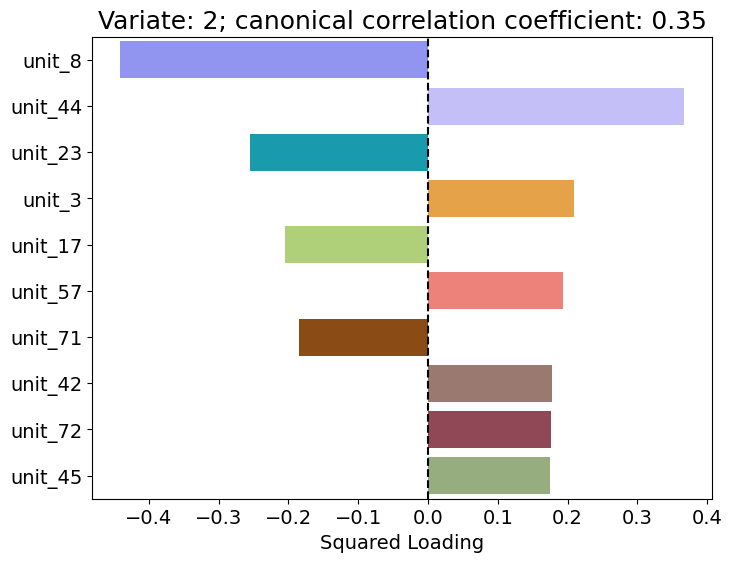

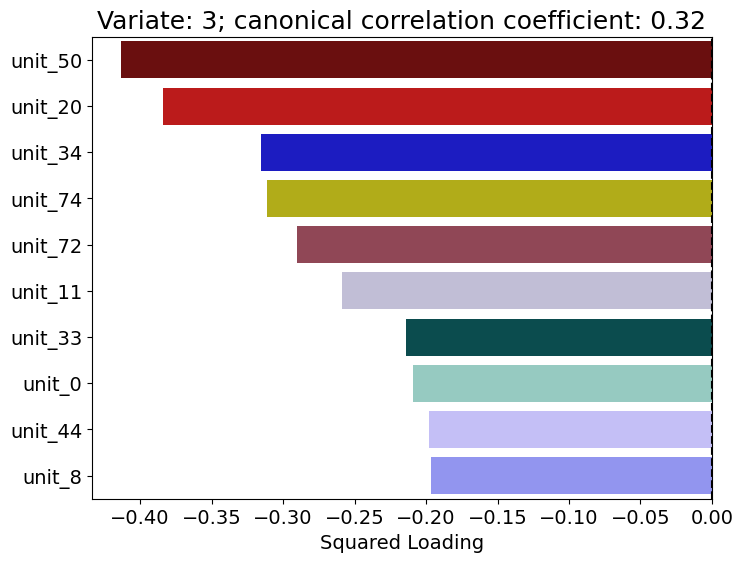

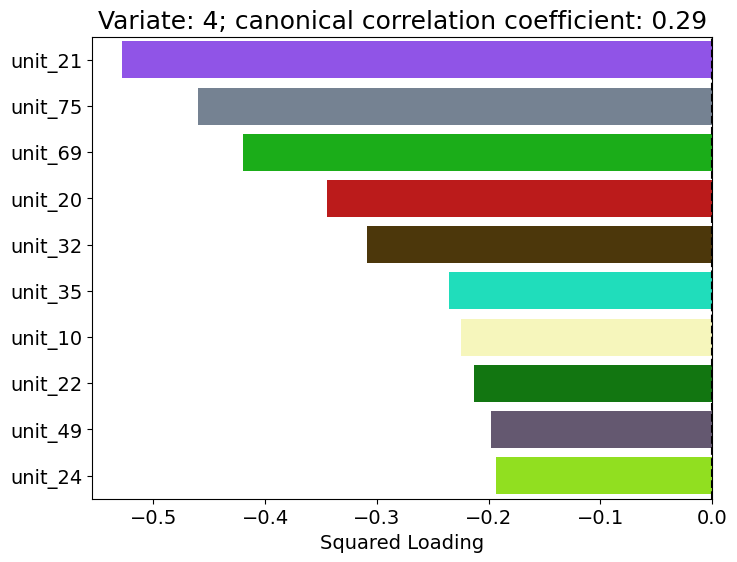

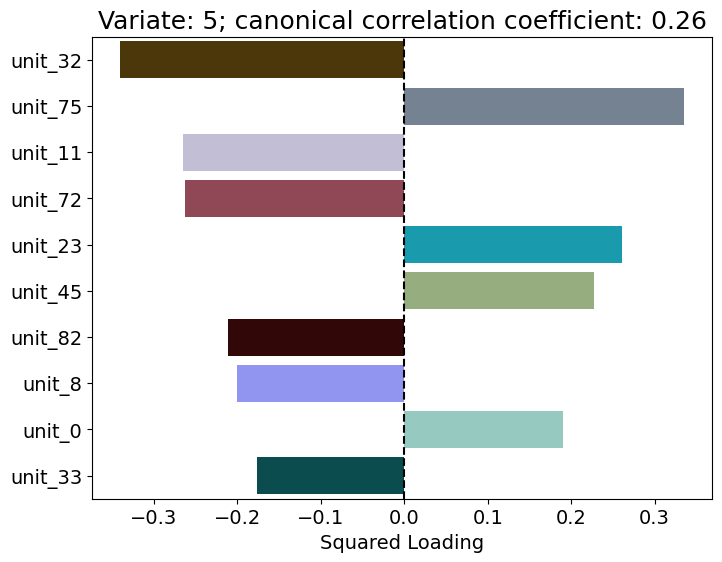

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1', squared=False)

### behavior

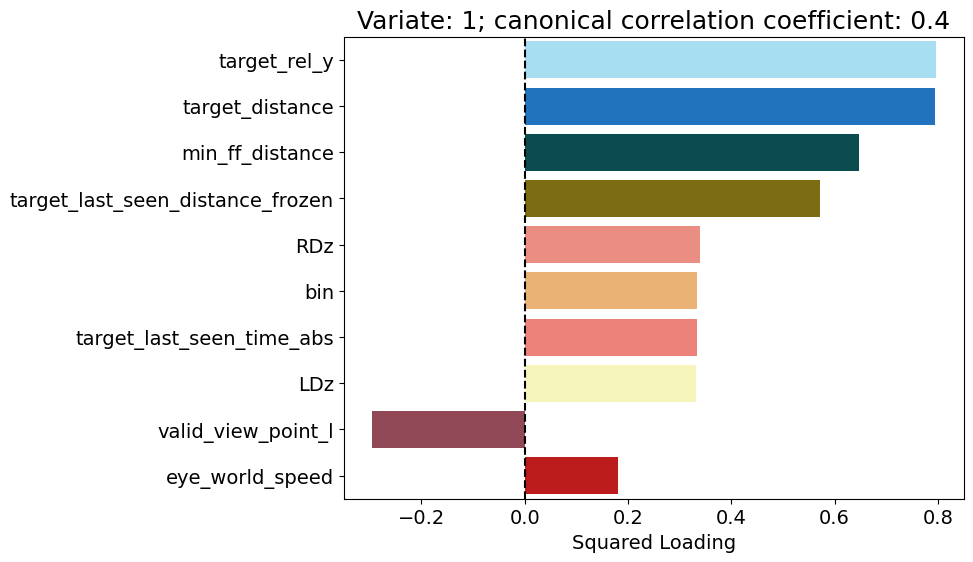

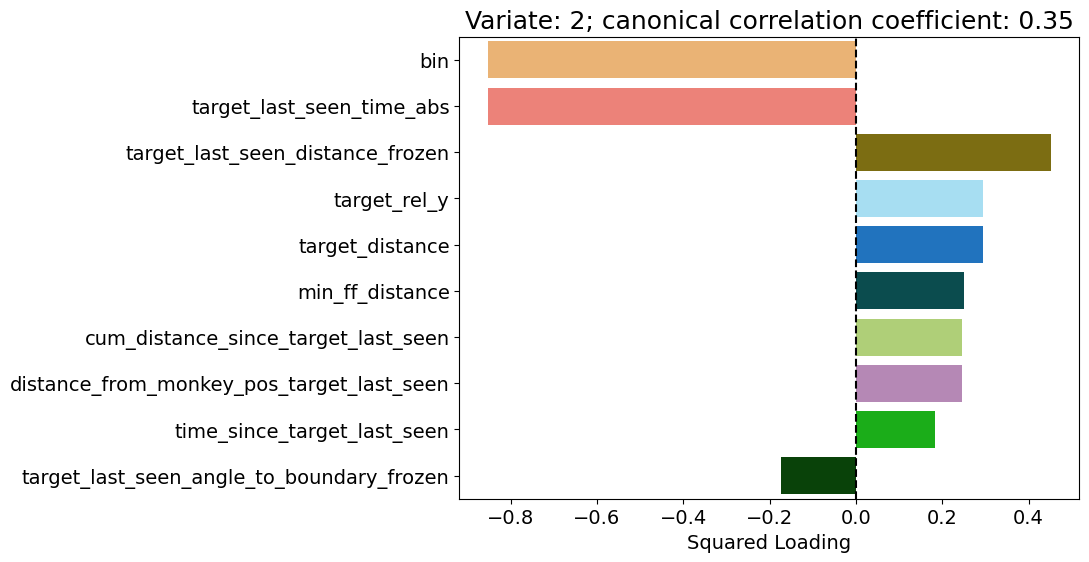

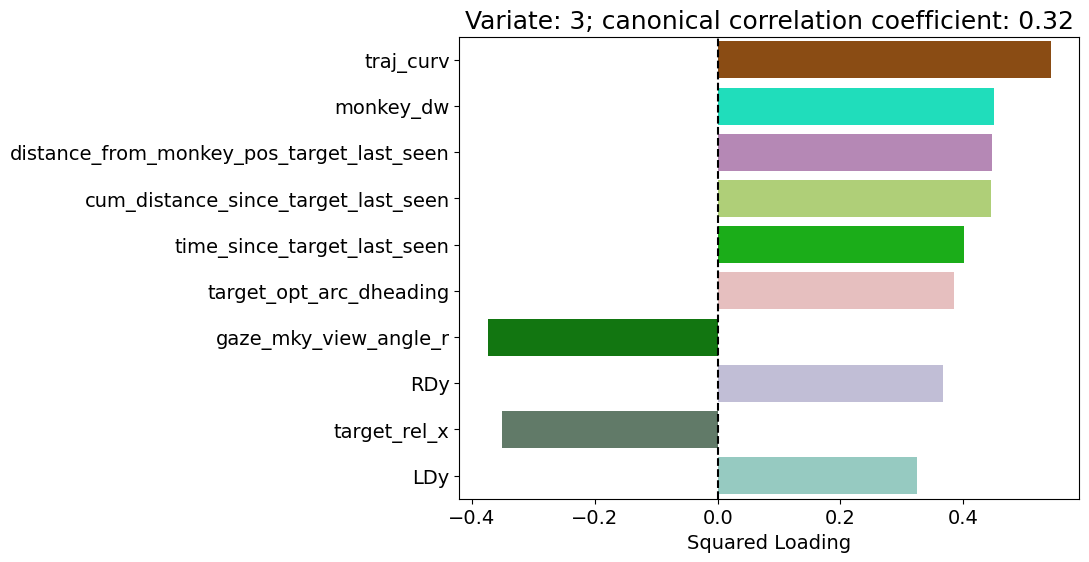

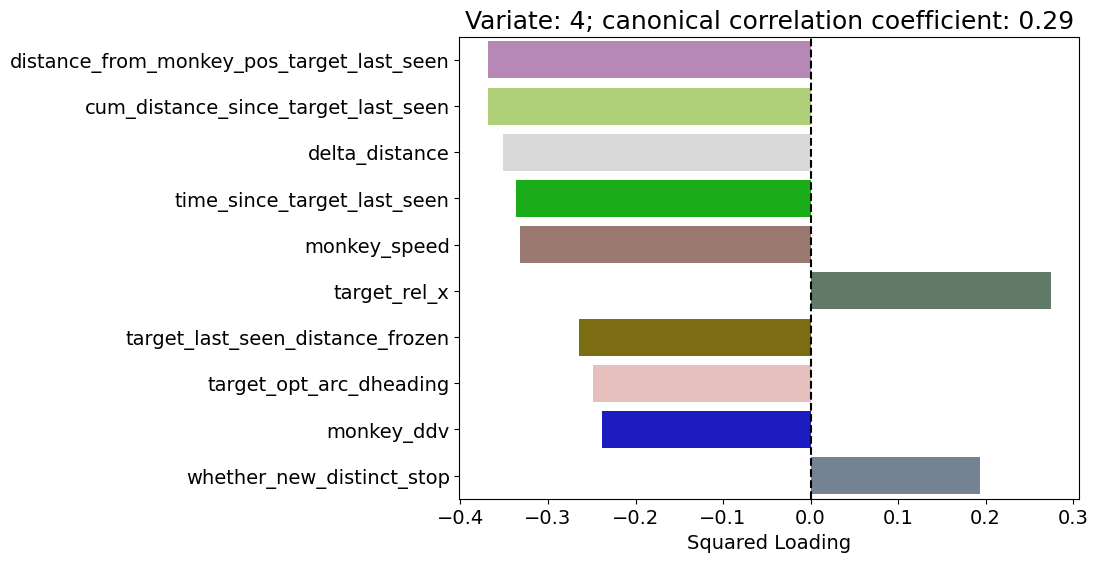

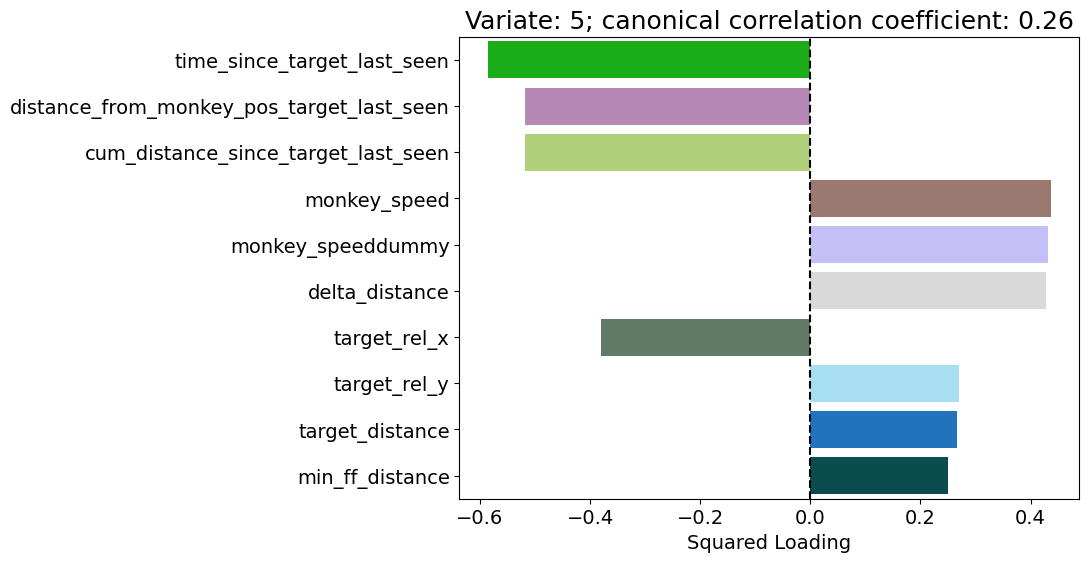

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2', squared=False)

## squared loadings

### neurons

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1')

### behavior

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2')

## abs weights ranked

### neurons

In [ ]:
cca_inst.plot_ranked_weights()

### behavior

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2')

## plot real weights

### neurons

In [ ]:
cca_inst.plot_ranked_weights(abs_value=False)

### behavior

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2', abs_value=False)

In [ ]:
stop here!

## distribution of each feature

In [ ]:
cca_inst.X2_sc.shape

In [ ]:
X2_sc_df = pd.DataFrame(cca_inst.X2_sc, columns = cca_inst.X2.columns)
X2_sc_df.describe()

In [ ]:
for column in X2_sc_df.columns:
    plt.figure(figsize=(8, 2))
    sns.boxplot(X2_sc_df[column], orient='h')
    plt.show()
    

## heatmap of weights
raw canonical coefficients are interpreted in a manner analogous to interpreting regression coefficients. For example: a one unit increase in reading leads to a .0446 decrease in the first canonical variate of set 2 when all of the other variables are held constant (in some other data)

In [ ]:
weight_df = cca_inst.X2_weight_df.copy()
weight_df = weight_df.set_index('feature').drop(columns='feature_category')

In [ ]:
plt.subplots(figsize=(15, 25))
sns.heatmap(weight_df.iloc[:20, :10], cmap='coolwarm', annot=True, linewidths=1)
plt.show()

## train test split

In [ ]:
train1, test1, train2, test2 = train_test_split(cca_inst.X1_sc, cca_inst.X2_sc, test_size=0.3, random_state=42)
# use training and testing set
nComponents = 10
cca2 = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents)
cca2.train([train1, train2])
testcorrs = cca2.validate([test1, test2])
testcorrs

## compute explained variance

In [ ]:
cca2.compute_ev([test1, test2])

## test for p values

In [ ]:
stats_cca = CanCorr(cca_inst.X1_sc, cca_inst.X2_sc)
print(stats_cca.corr_test().summary())
neural_data_modeling.print_weights('X', stats_cca.x_cancoef)
neural_data_modeling.print_weights('Z', stats_cca.y_cancoef)

In [ ]:
stop pls

# PGAM (unfinished)

In [ ]:
## Categorize variables
dec.y_var_reduced.columns
temporal_vars = ['time_rel_to_stop',
 'time_when_nxt_ff_first_seen_rel_to_stop',
 'time_when_cur_ff_first_seen_rel_to_stop',
 'time_when_nxt_ff_last_seen_rel_to_stop',
 'time_when_cur_ff_last_seen_rel_to_stop',
 ]

spatial_vars = [x for x in dec.y_var_reduced.columns if x not in temporal_vars]
spatial_vars

# Inspect data

## sparsity of neural data

In [ ]:
dec.binned_spikes_df.shape

In [ ]:
# inspect neural data

bins = dec.binned_spikes_df

# Calculate percentage of non-zero rows for each column
non_zero_percentages = (bins != 0).mean() * 100

# Create a DataFrame with the results
non_zero_df = pd.DataFrame({
    'Column': non_zero_percentages.index,
    'Percent_Non_Zero': non_zero_percentages.values
})

# Sort by percentage in descending order
non_zero_df = non_zero_df.sort_values('Percent_Non_Zero', ascending=False)

print("Percentage of non-zero values in each column:")
print(non_zero_df)


In [ ]:
bins.drop(columns='bin').mean(axis=1).describe()

# plot the percentile of values of mean firing rates across neurons at each time bin
mean_rates = bins.drop(columns='bin').mean(axis=1)

# Calculate percentiles from 0 to 100
percentiles = np.arange(0, 101, 1)
percentile_values = np.percentile(mean_rates, percentiles)

# Create plot
plt.figure(figsize=(6, 4))
plt.plot(percentiles, percentile_values)
plt.xlabel('Percentile')
plt.ylabel('Mean Firing Rate')
plt.title('Distribution of Mean Firing Rates Across Neurons')
plt.grid(True)
plt.show()


## multicollinearity

### y var (behavioral)

In [ ]:
y_var_vif = drop_high_vif_vars.get_vif_df(dec.y_var)
print(y_var_vif.head(8))

# calculate the correlation coefficient among the columns with VIF > 5
# specific_columns = vif_df[vif_df['vif'] > 5].feature.values
specific_columns = y_var_vif.feature.values[:10]
corr_coeff = dec.y_var[specific_columns].corr()
#plt.figure(figsize = (6, 6))
plt.figure(figsize = (8, 6))
sns.heatmap(corr_coeff, cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

In [ ]:
# Try y_var_reduced

y_var_vif = drop_high_vif_vars.get_vif_df(dec.y_var_reduced)
print(y_var_vif.head(8))

# calculate the correlation coefficient among the columns with VIF > 5
# specific_columns = vif_df[vif_df['vif'] > 5].feature.values
specific_columns = y_var_vif.feature.values[:10]
corr_coeff = dec.y_var[specific_columns].corr()
#plt.figure(figsize = (6, 6))
plt.figure(figsize = (8, 6))
sns.heatmap(corr_coeff, cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

## plot trial segments in pursuit_data

In [ ]:
from visualization.matplotlib_tools import plot_trials,
dec.make_PlotTrials_args()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]                     

max_plot_to_make = 2
plot_counter = 0

for index, row in dec.single_vis_target_df.iloc[2:].iterrows():

    duration = [row['last_vis_time'], row['ff_caught_time']]

    returned_info = plot_trials.PlotTrials(
                duration, 
                *dec.PlotTrials_args,  
                adjust_xy_limits=True,       
                minimal_margin=50,
                show_reward_boundary=True,
                show_alive_fireflies=False,
                show_visible_fireflies=True,
                show_in_memory_fireflies=True,
                show_believed_target_positions=True,
                )
    plt.show()
    

    plot_counter += 1
    if plot_counter >= max_plot_to_make:
        break

### check target_rel_x and y
(The look correct after checking)

In [ ]:
pursuit_sub = dec.pursuit_data.loc[dec.pursuit_data['target_index']==65].copy()
pursuit_sub['target_angle_deg'] = pursuit_sub['target_angle'] * 180/pi 

In [ ]:
pursuit_sub[['point_index', 'target_angle_deg', 'target_distance', 'target_rel_x', 'target_rel_y']]

# Appendix

## check NA

In [ ]:
na_rows, na_cols = general_utils.find_rows_with_na(dec.y_var)
duplicate_rows = general_utils.find_duplicate_rows(dec.y_var, column_subset=None)

No NA values found in the dataframe

🔍 Duplicate Rows Analysis:
No duplicate rows found in the dataframe


## See sizes of biggest variables

### in dec

In [ ]:
from pympler import asizeof

sizes = []
for attr in dir(dec):
    if attr.startswith('__') and attr.endswith('__'):
        continue  # skip dunder attributes
    try:
        val = getattr(dec, attr)
        size = asizeof.asizeof(val)
        sizes.append((attr, size))
    except Exception:
        pass  # ignore any errors

# Sort and display largest attributes in MB
for name, size in sorted(sizes, key=lambda x: x[1], reverse=True):
    print(f"{name}: {size / (1024 * 1024):.2f} MB")


behav_data: 389.82 MB
binned_spikes_df: 239.04 MB
x_var_lags: 234.83 MB
behav_data_all: 229.43 MB
y_var_lags: 153.08 MB
x_var: 14.26 MB
y_var: 9.95 MB
pursuit_data: 9.69 MB
y_var_reduced: 9.45 MB
pursuit_data_by_trial: 8.03 MB
time_bins: 3.97 MB
ff_flash_sorted: 3.45 MB
target_clust_last_vis_df: 0.31 MB
single_vis_target_df: 0.24 MB
closest_stop_to_capture_df: 0.09 MB
ff_closest_stop_time_sorted: 0.02 MB
ff_life_sorted: 0.02 MB
ff_real_position_sorted: 0.02 MB
ff_flash_end_sorted: 0.01 MB
ff_index_sorted: 0.01 MB
ff_believed_position_sorted: 0.01 MB
ff_caught_T_new: 0.00 MB
ff_caught_T_sorted: 0.00 MB
bin_width_w_unit: 0.00 MB
curv_of_traj_params: 0.00 MB
y_columns_to_drop: 0.00 MB
lag_numbers: 0.00 MB
x_lag_numbers: 0.00 MB
convolve_pattern: 0.00 MB
lr_result_df_path: 0.00 MB
vif_df_path: 0.00 MB
y_var_lags_path: 0.00 MB
patterns_and_features_data_folder_path: 0.00 MB
processed_neural_data_folder_path: 0.00 MB
decision_making_folder_path: 0.00 MB
neural_data_folder_path: 0.00 MB
proce

### global

In [ ]:
import types
import warnings
from pympler import asizeof

warnings.filterwarnings("ignore", category=UserWarning)


filtered = {
    k: v for k, v in globals().items()
    if not isinstance(v, types.ModuleType)
}

sizes = []
for name, val in filtered.items():
    try:
        sizes.append((name, asizeof.asizeof(val)))
    except:
        pass

for name, size in sorted(sizes, key=lambda x: x[1], reverse=True)[:20]:
    print(f"{name}: {size / (1024 * 1024):.2f} MB")


quit: 1089.19 MB
exit: 1089.19 MB
user_vars: 1088.96 MB
filtered: 1088.96 MB
sorted_vars: 1088.41 MB
current_globals: 1076.42 MB
dec: 1076.27 MB
_oh: 9.79 MB
Out: 9.79 MB
_13: 9.79 MB
sizes: 0.01 MB
_ih: 0.01 MB
In: 0.01 MB
var: 0.00 MB
_i1: 0.00 MB
exclude_names: 0.00 MB
_dh: 0.00 MB
_i20: 0.00 MB
_i19: 0.00 MB
_ii: 0.00 MB


## more columns (possibly get in the future)

get also get: (but to be honest, it doesn't make that much sense to get them....so let's skip for now.)
'distance traversed since target last visible',
'd angle since target last visible', 'target_at_right',
'time_till_capture', 'time from last visible to capture

Note that there might be multicollinearity. For example, duration from last visible to capture = time since target last visible + time till capture

Similarly, target angle = target angle last seen frozen - d angle since target last visible

(For distance it's not exactly the same because of the difference between distance and distance traversed, but it's still similar)

The multicollinearity is fine in linear regression (when each feature here is a y var), but need to be dealt with in cca.

## other thoughts

should i actually align each section, as if they are trials???
maybe i can try both that and continuous time... both can shed light on different behavioral variables
but for aligning trials, it may require alignment or warping since trial durations vary.

btw, what does it mean stitch data?

also, what does it look like to use RNN to model it?
I thought about the paper that Noah presented on


btw.......IME

## why ratio of bin/target_index approaches constant

In [ ]:
trial_lengths = dec.pursuit_data[['target_index', 'bin']].groupby('target_index').count()
trial_lengths.describe()

In [ ]:
sub = dec.y_var_reduced[['time', 'bin', 'target_index']]
sub['factor'] = dec.y_var_reduced['bin']/dec.y_var_reduced['target_index']
sub

In [ ]:
plt.hist(np.diff(dec.ff_caught_T_sorted), bins=30)
plt.xlabel('Time difference')
plt.ylabel('Count')
plt.title('Distribution of time differences between caught events')
plt.show()


In [ ]:
dec.ff_caught_T_sorted/np.arange(len(dec.ff_caught_T_sorted))

## compared with neural_data_modeling

In [ ]:
dec = neural_vs_behavioral_class.NeuralVsBehavioralClass(raw_data_folder_path=raw_data_folder_path)
dec.streamline_preparing_neural_and_behavioral_data()

In [ ]:
dec.final_behavioral_data

In [ ]:
dec.y_var

In [ ]:
dec.y_var_reduced

In [ ]:
dec.y_var.columns

In [ ]:
dec.y_var_reduced.columns

In [ ]:
[col for col in dec.y_var.columns if col not in dec.y_var_reduced.columns]

In [ ]:
[col for col in dec.y_var_reduced.columns if col not in dec.y_var.columns]

## Check gpfa's binned spikes vs my own binned spikes

In [ ]:
spike_segs_df = fit_gpfa_utils.make_spike_segs_df(dec.spike_df, dec.single_vis_target_df)


### get binned spikes (seqs) from gpfa_utils.

In [ ]:
seg_index = 9
cluster_index = 12
seg = dec.spiketrain_corr_segs[seg_index]
cluster = dec.spike_segs_df.cluster.unique()[cluster_index]

spiketrain = dec.spiketrains[seg_index][cluster_index]
seqs = gpfa_util.get_seqs([spiketrain], dec.bin_width_w_unit)

### take out my own binned spikes

In [ ]:
p_sub = dec.pursuit_data_all[dec.pursuit_data_all['segment']==seg]
binned_spikes_sub = dec.binned_spikes_df[dec.binned_spikes_df['bin'].isin(p_sub['bin'])].copy()
binned_spikes_sub['bin'] = binned_spikes_sub.index
binned_spikes_sub2 = binned_spikes_sub.merge(p_sub[['bin', 'time']], on='bin', how='left')
binned_spikes_sub3 = binned_spikes_sub2[['bin', 'time', f'unit_{cluster}']].copy()

### compare

In [ ]:
trial_length = len(binned_spikes_sub3)
if dec.align_at_beginning:
    binned_spikes_sub3['gpfa'] = seqs[0][1][0][trial_length:]
else:
    binned_spikes_sub3['gpfa'] = seqs[0][1][0][-trial_length:] # when getting latent dimension for neural data, [-trial_length:] was also used
binned_spikes_sub3['same'] = binned_spikes_sub3[f'unit_{cluster}'] == binned_spikes_sub3['gpfa']
binned_spikes_sub3[binned_spikes_sub3['same']!=True]

## find out why there are rows of NA in dec.y_var

In [ ]:
na_rows, na_cols = general_utils.find_rows_with_na(dec.y_var)
duplicate_rows = general_utils.find_duplicate_rows(dec.y_var, column_subset=None)


NA Values Analysis for DataFrame (10,752 rows)

Columns with NA values:
------------------------------------------------------------
bin                                            10 (   0.1%)
point_index                                    10 (   0.1%)
monkey_speed                                   10 (   0.1%)
monkey_angle                                   10 (   0.1%)
monkey_dw                                      10 (   0.1%)
monkey_ddw                                     10 (   0.1%)
monkey_ddv                                     10 (   0.1%)
monkey_speeddummy                              10 (   0.1%)
whether_new_distinct_stop                      10 (   0.1%)
delta_distance                                 10 (   0.1%)
LDy                                            10 (   0.1%)
LDz                                            10 (   0.1%)
RDy                                            10 (   0.1%)
RDz                                            10 (   0.1%)
gaze_mky_view_x_l         

In [ ]:
dec.behav_data_all.loc[118189:118195, ['bin', 'time', 'target_rel_x', 'target_rel_y','time_since_target_last_seen', 'target_last_seen_distance']]

,bin,time,target_rel_x,target_rel_y,time_since_target_last_seen,target_last_seen_distance_frozen
118189,118189,2363.79357,-28.19543,146.38031,100.00000,400.00000
118190,118190,2363.81014,-27.87834,146.44103,100.00000,400.00000
118191,118191,2363.82676,-27.83208,146.44983,100.00000,400.00000
118192,118192,2363.84340,-27.23474,146.56209,100.00000,400.00000
118193,118193,2363.87655,-30.89287,92.84220,0.03315,97.84704
118194,118194,2363.89316,-30.89386,92.77966,0.04976,97.84704
118195,118195,2363.90980,-30.89685,92.59225,0.06640,97.84704


## Compare old and new target df

In [ ]:
target_df_ori = pd.read_csv('/Users/dusiyi/Documents/Multifirefly-Project/all_monkey_data/patterns_and_features/monkey_Schro/data_0416/target_df_ori.csv')
df = target_df_ori[['target_index', 'point_index', 'time']].copy()
for col in ['target_distance', 'time_since_target_last_seen']:
    df[f'old_{col}'] = target_df_ori[col]   
    df[f'new_{col}'] = dec.target_df[col]  

df['old_target_last_seen_distance'] = target_df_ori['target_last_seen_distance_frozen']
df['new_target_last_seen_distance'] = dec.target_df['target_last_seen_distance']

df2 = df.loc[10068:]
df2

,target_index,point_index,time,old_target_distance,new_target_distance,old_time_since_target_last_seen,new_time_since_target_last_seen,old_target_last_seen_distance,new_target_last_seen_distance
10068,43,10068,166.25916,11.10407,11.10407,0.46470,0.46470,64.16406,64.16406
10069,43,10069,166.27583,11.30408,11.30408,0.48137,0.48137,64.16406,64.16406
10070,43,10070,166.29243,11.30411,11.30411,0.49797,0.49797,64.16406,64.16406
10071,44,10071,166.30901,564.26537,564.26537,85.88753,NaN,274.47807,NaN
10072,44,10072,166.32559,564.26537,564.26537,85.90411,NaN,274.47807,NaN
...,...,...,...,...,...,...,...,...,...
217186,469,217186,3598.88691,10.55384,10.55384,1229.88084,NaN,142.18819,NaN
217187,469,217187,3598.90334,10.55384,10.55384,1229.89728,NaN,142.18819,NaN
217188,470,217188,3598.91992,1144.91909,1144.91909,100.00000,NaN,400.00000,NaN
217189,470,217189,3598.93653,1144.91909,1144.91909,100.00000,NaN,400.00000,NaN


In [ ]:
df3 = df2[df2['point_index']>= 139910]
df3

,time,point_index,target_index,time_since_target_last_seen,target_last_seen_distance,...,target_last_seen_angle_to_boundary,time_target_last_seen,distance_from_monkey_pos_target_last_seen,cum_distance_since_target_last_seen,d_heading_since_target_last_seen
10255,2316.60015,139913,450,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
10256,2316.63349,139915,450,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
10257,2316.65003,139916,450,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
10258,2316.66659,139917,450,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
10259,2316.68324,139918,450,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10747,3597.44249,217097,468,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
10748,3597.47576,217099,468,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
10749,3597.49224,217100,468,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
10750,3597.50893,217101,468,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


In [ ]:
139913